In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from imblearn.over_sampling import SMOTE

In [2]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [3]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [4]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


# Background

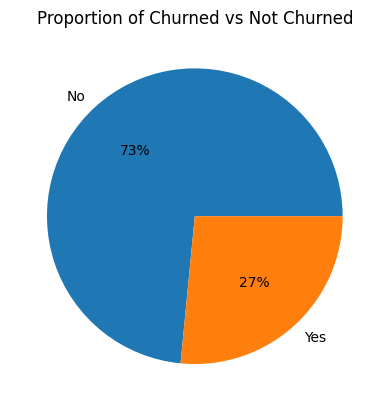

In [5]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

27% of passengers churned from purchasing

In [6]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future gone.

Around `Rp180,870,800.00` stripped out from the company's monthly income.

# EDA

## Univariate

### Original

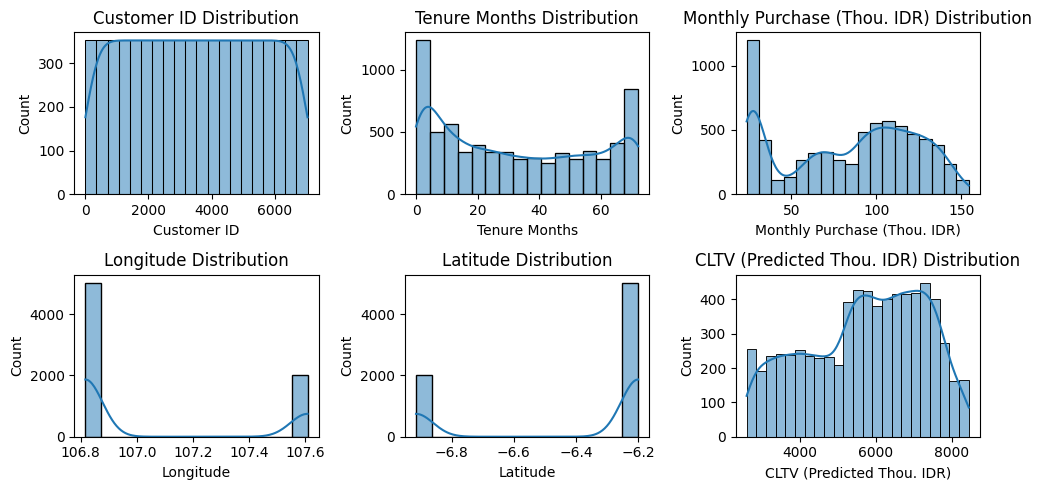

In [7]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

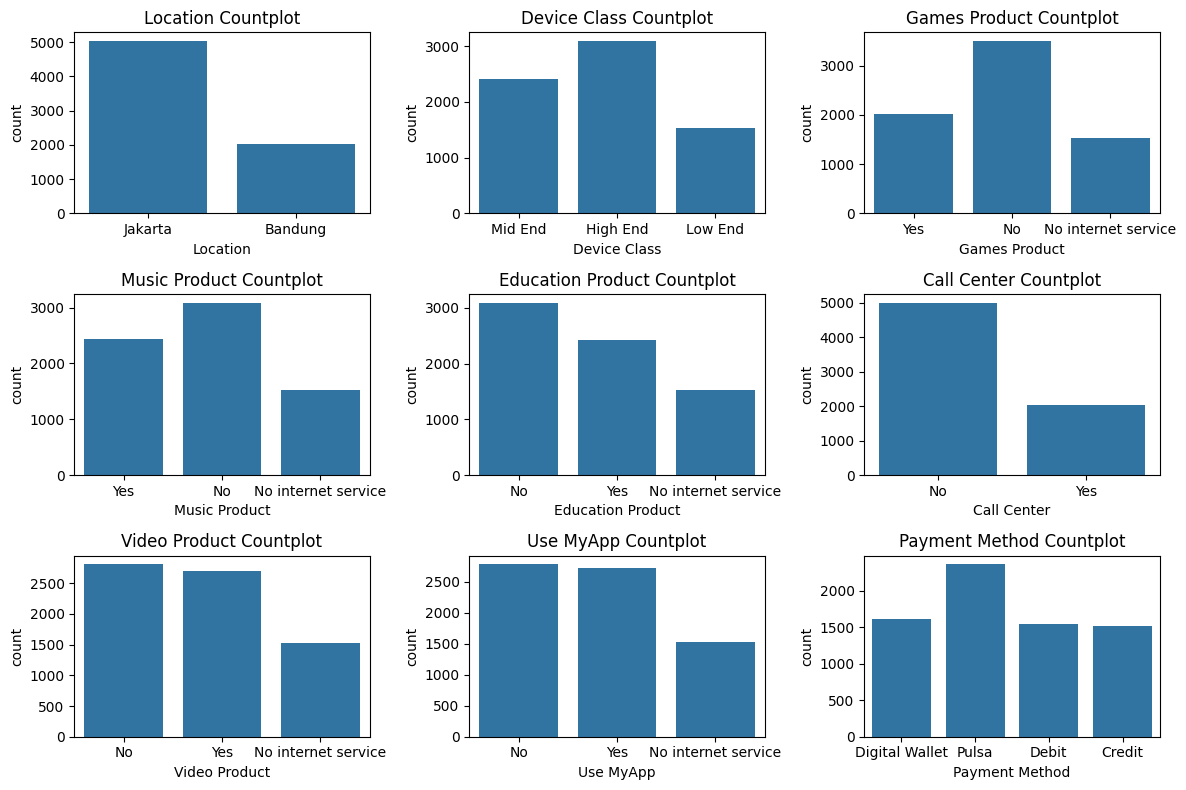

In [8]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Hue `Churn Label`

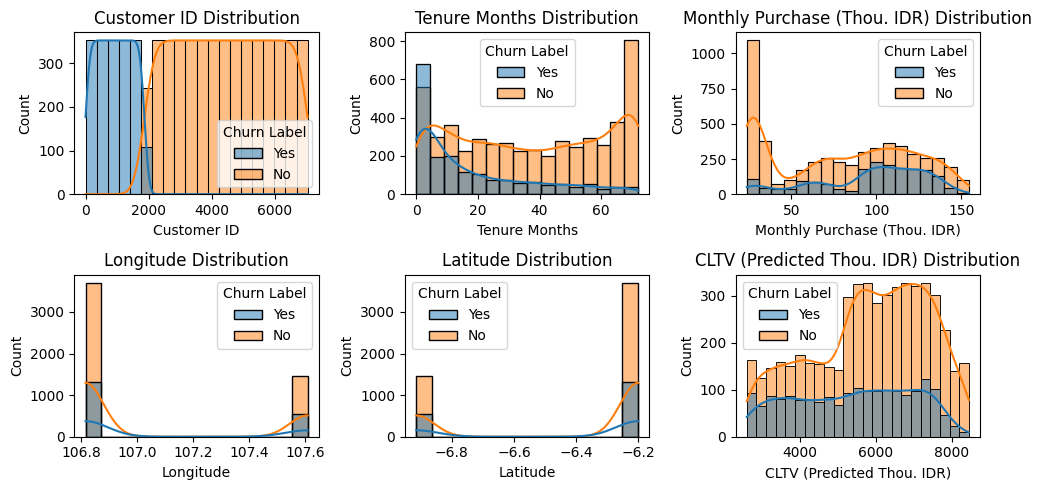

In [9]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], hue="Churn Label", kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

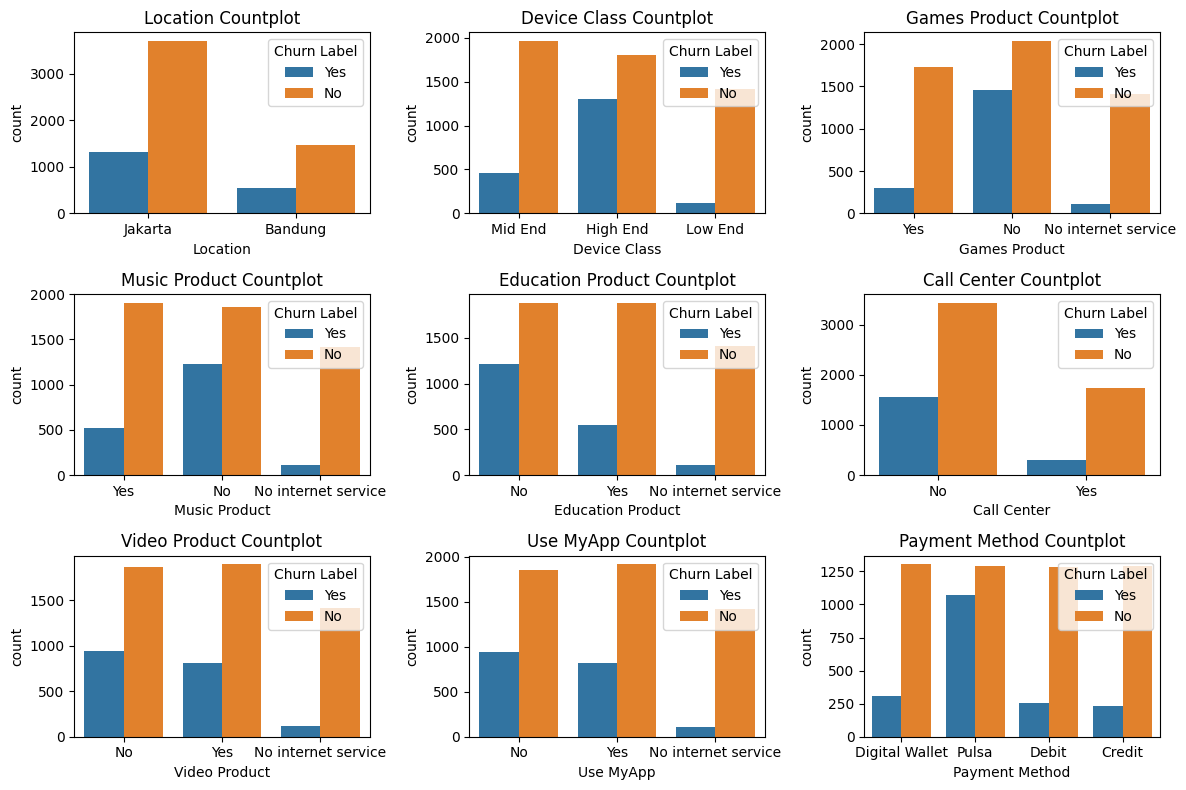

In [10]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], hue='Churn Label', ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Skew

In [11]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    skewness = df[col].skew()
    if skewness < -0.5: 
        print(f"{col}, skewness: {skewness}, left skewed")
    elif skewness > 0.5: 
        print(f"{col}, skewness: {skewness}, right skewed")
    else: 
        print(f"{col}, skewness: {skewness}, approximately symmetric")

Customer ID, skewness: 0.0, approximately symmetric
Tenure Months, skewness: 0.2395397495619829, approximately symmetric
Monthly Purchase (Thou. IDR), skewness: -0.2205244339439807, approximately symmetric
Longitude, skewness: 0.9491054700666193, right skewed
Latitude, skewness: -0.9491054700664001, left skewed
CLTV (Predicted Thou. IDR), skewness: -0.3116021004049805, approximately symmetric


### Kurtosis

In [12]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    kurtosis = df[col].kurtosis()
    if kurtosis > 3:
        print(f"{col}, kurtosis: {kurtosis}, leptokurtic (heavy tailed, more chance of outliers)")
    elif kurtosis < 3:
        print(f"{col}, kurtosis: {kurtosis}, platykurtic")
    else:
        print(f"{col}, kurtosis: {kurtosis}, mesokurtic")

Customer ID, kurtosis: -1.1999999999999997, platykurtic
Tenure Months, kurtosis: -1.3873716359716848, platykurtic
Monthly Purchase (Thou. IDR), kurtosis: -1.2572596945495054, platykurtic
Longitude, kurtosis: -1.099511115413302, platykurtic
Latitude, kurtosis: -1.0995111154135797, platykurtic
CLTV (Predicted Thou. IDR), kurtosis: -0.9340324830072797, platykurtic


## Device Class

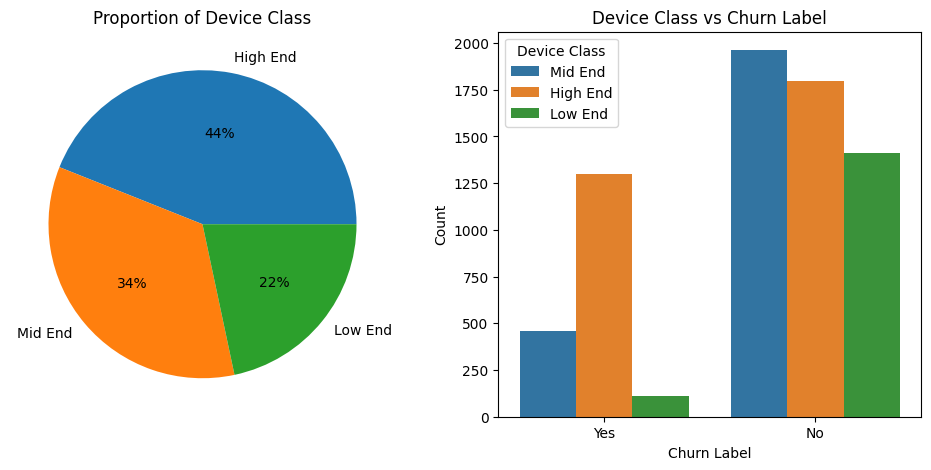

In [13]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Device Class
# =================================================================
plot_df = df["Device Class"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Device Class")

# Device Class vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Device Class', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Device Class vs Churn Label")
plt.show()

1. `~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn.
2. The proportion is dominated by **High End**, followed by **Mid End** and **Low End**

## Location

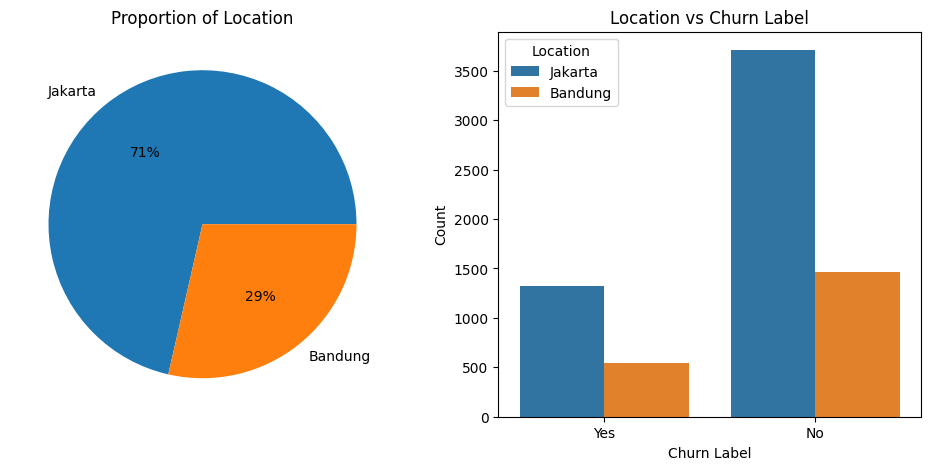

In [14]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Location
# =================================================================
plot_df = df["Location"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Location")

# Location vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Location', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Location vs Churn Label")
plt.show()

In [15]:
location_churn = df.pivot_table(values="Customer ID", index="Churn Label", columns="Location", aggfunc="count", margins=True)
location_churn / location_churn.loc["All", :]

Location,Bandung,Jakarta,All
Churn Label,,,
No,0.728628,0.73703,0.73463
Yes,0.271372,0.26297,0.26537
All,1.000000,1.00000,1.00000


1. Jakarta has the highes churn rate, but It's due to inequality of proportion between users from **Jakarta** and **Bandung**
2. The changes of user either from `Bandung` and `Jakarta` are almost the same. 

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [16]:
# change label of product and app
def preprocess_data(df):
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    # prod_app_map = {
    #     "Yes": 1,
    #     "No": 0,
    #     "No internet service": 0,
    # }
    # df['Games Product'] = df['Games Product'].replace(prod_app_map)
    # df['Music Product'] = df['Music Product'].replace(prod_app_map)
    # df['Education Product'] = df['Education Product'].replace(prod_app_map)
    # df['Video Product'] = df['Video Product'].replace(prod_app_map)
    # df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

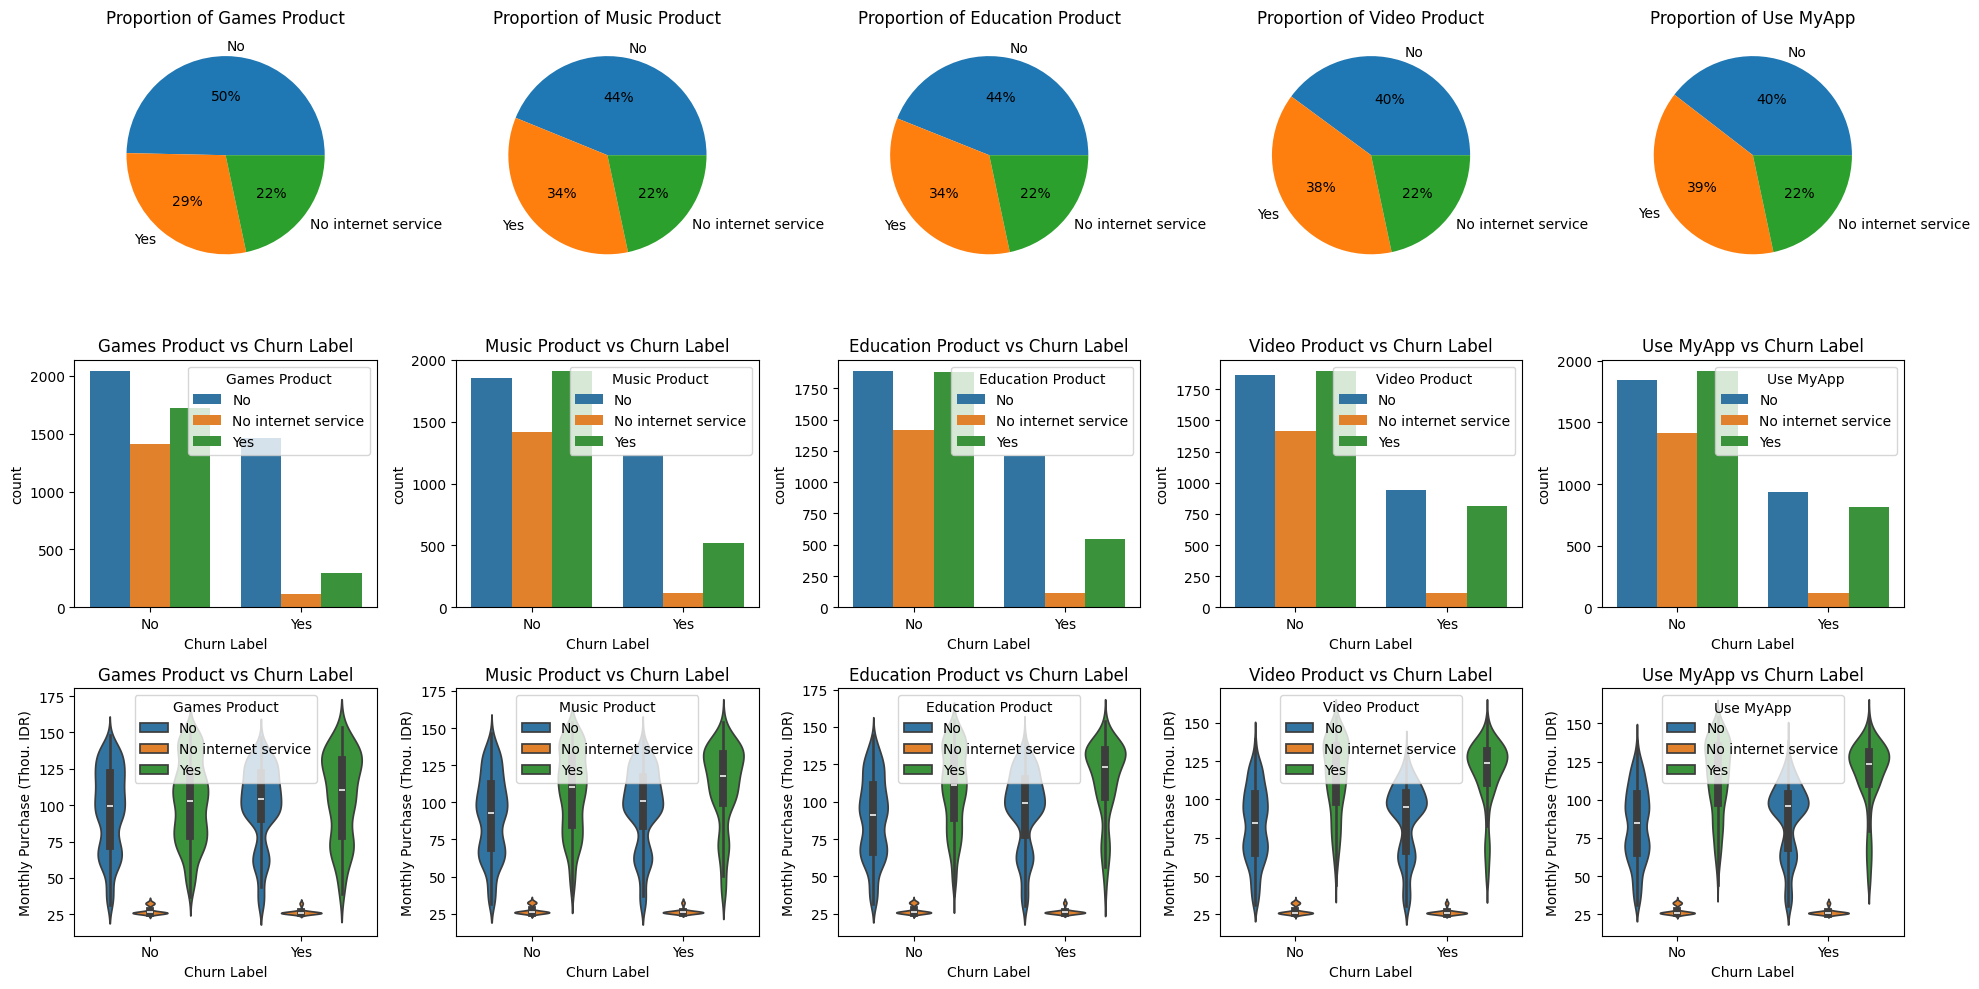

In [17]:

cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 10))

for i, c in enumerate(cols):
    plot_df = df[c].value_counts(normalize=True) * 100
    ax[0][i].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
    ax[0][i].set_title(f"Proportion of {c}")
    

for i, c in enumerate(cols):
    sns.countplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', hue=c, ax=ax[1][i])
    ax[1][i].set_title(f"{c} vs Churn Label")
    
    
for i, c in enumerate(cols):
    sns.violinplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', y="Monthly Purchase (Thou. IDR)", hue=c, ax=ax[2][i])
    ax[2][i].set_title(f"{c} vs Churn Label")

fig.tight_layout()

1. People who didn't use internet service for Games, Music, and Education Product has a higher change of churn.
2. People who's monthly purchase is around **100K** and didn't use the internet service for any of the products has more change of churning
3. People who's monthly purchase is around **125K** and didn't use the internet service for any of the products has more change of churning

Users who churned they don't use the internet service for accessing those products

## Payment Method

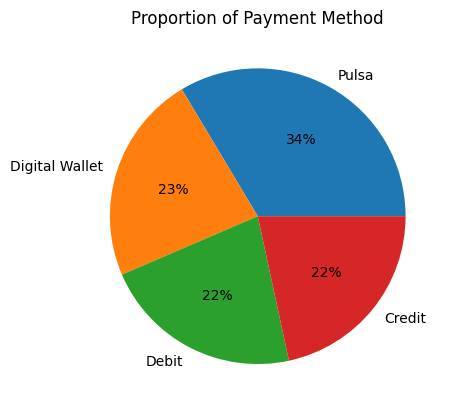

In [18]:
plot_df = df["Payment Method"].value_counts(normalize=True) * 100
plt.pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
plt.title(f"Proportion of Payment Method")
plt.show()

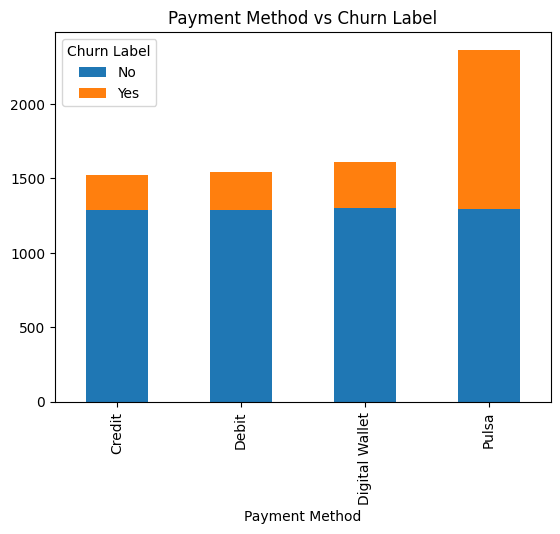

In [19]:
plot_df = df.pivot_table(index="Payment Method", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

In [20]:
churn_payment_method = df.pivot_table(index="Payment Method", columns="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Churn,0,1
Payment Method,,
Credit,0.249324,0.124131
Debit,0.248550,0.138042
Digital Wallet,0.252029,0.164794
Pulsa,0.250097,0.573034


1. Users buy using pulsa has high change of churn

## Tenure Months

In [21]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


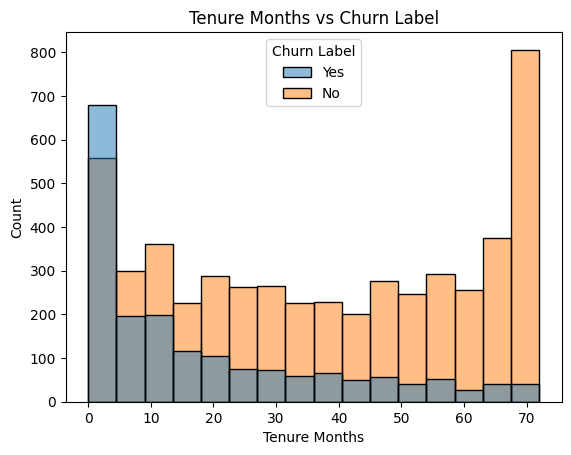

In [22]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

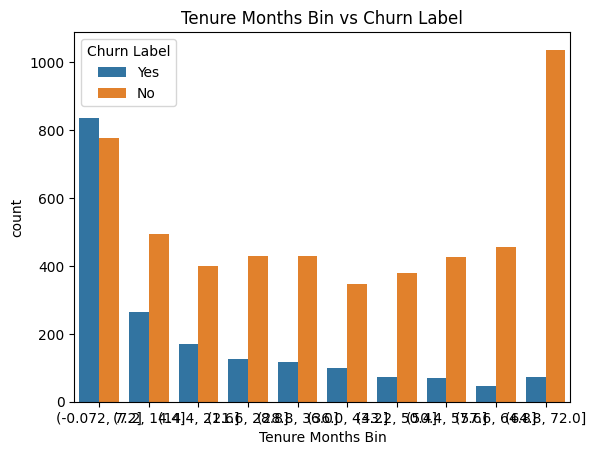

In [23]:
df['Tenure Months Bin'] = pd.cut(df['Tenure Months'], bins=10)
ax = sns.countplot(data=df, x='Tenure Months Bin', hue='Churn Label')
plt.title("Tenure Months Bin vs Churn Label")
plt.show()

User with low tenure has a high change of churning especially from 0 to 10 months tenure

## Monthly Purchase

In [24]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

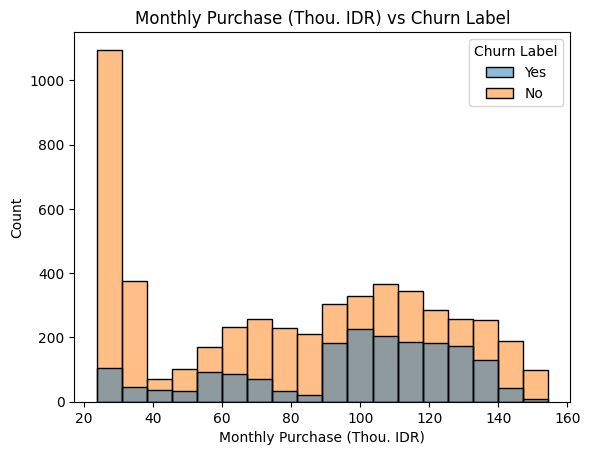

In [25]:
sns.histplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 100,000.00 - Rp 120,000.00 a month.

## CLTV

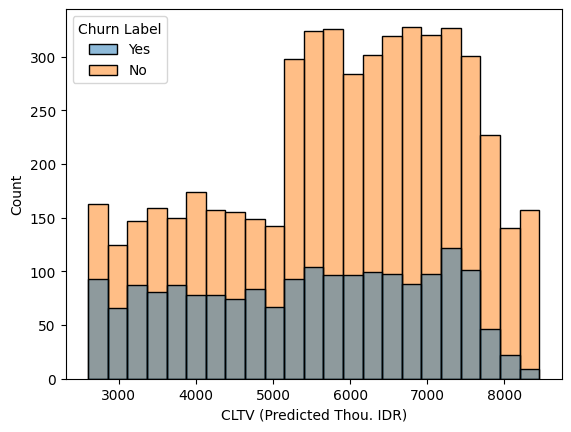

In [26]:
sns.histplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature. The CLTV above Rp 7,500,000 has a high chance of churning.

## Call Center
Check whether the customer uses the call center service

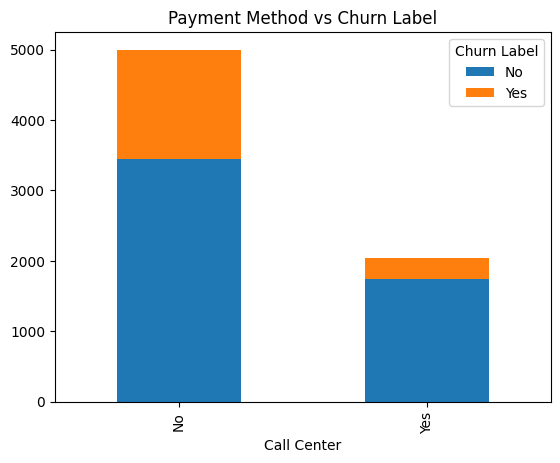

In [27]:
plot_df = df.pivot_table(index="Call Center", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

## Total Purchase

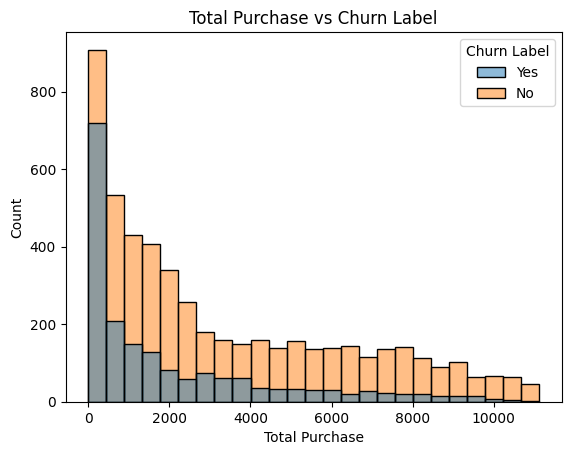

In [28]:
sns.histplot(data=df, x="Total Purchase", hue="Churn Label")
plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

In [29]:
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Internet Service,Churn,Total Purchase,Tenure Months Bin
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7,1,1,140.01,"(-0.072, 7.2]"
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3,1,1,183.82,"(-0.072, 7.2]"
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6,1,1,1036.36,"(7.2, 14.4]"
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9,1,1,3814.72,"(21.6, 28.8]"
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0,1,1,6605.69,"(43.2, 50.4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,27.495,No,106.816666,-6.2,6897.8,0,0,1979.64,"(64.8, 72.0]"
7039,7039,24,Jakarta,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,110.240,No,106.816666,-6.2,2782.0,1,0,2645.76,"(21.6, 28.8]"
7040,7040,72,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Credit,134.160,No,106.816666,-6.2,7228.0,1,0,9659.52,"(64.8, 72.0]"
7041,7041,11,Jakarta,Mid End,Yes,No,No,No,No,No,Pulsa,38.480,No,106.816666,-6.2,3630.9,1,0,423.28,"(7.2, 14.4]"


## Used Products

<function matplotlib.pyplot.show(close=None, block=None)>

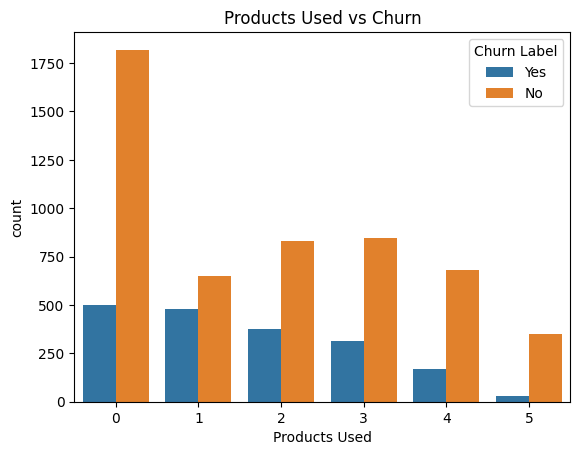

In [30]:
def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

# Total Product Used
df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp']]\
    .apply(lambda x: uses_internet_for_product(x['Games Product'])
        + uses_internet_for_product(x['Music Product'])
        + uses_internet_for_product(x['Education Product'])
        + uses_internet_for_product(x['Video Product'])
        + uses_internet_for_product(x['Use MyApp']), axis=1)

sns.countplot(data=df, x="Products Used", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show
# df

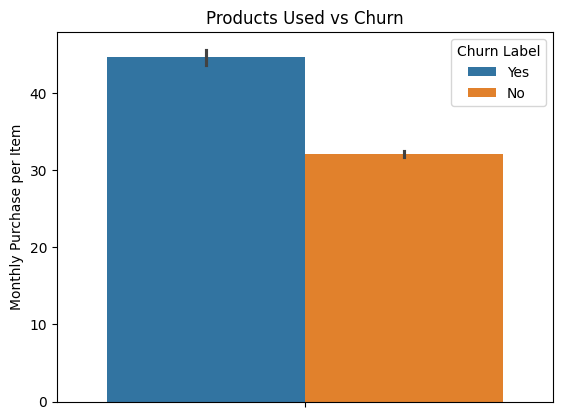

In [31]:
df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)

sns.barplot(data=df, y="Monthly Purchase per Item", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show()

User that pay more and use little of the product services has a high chance of churning

## Correlation Map

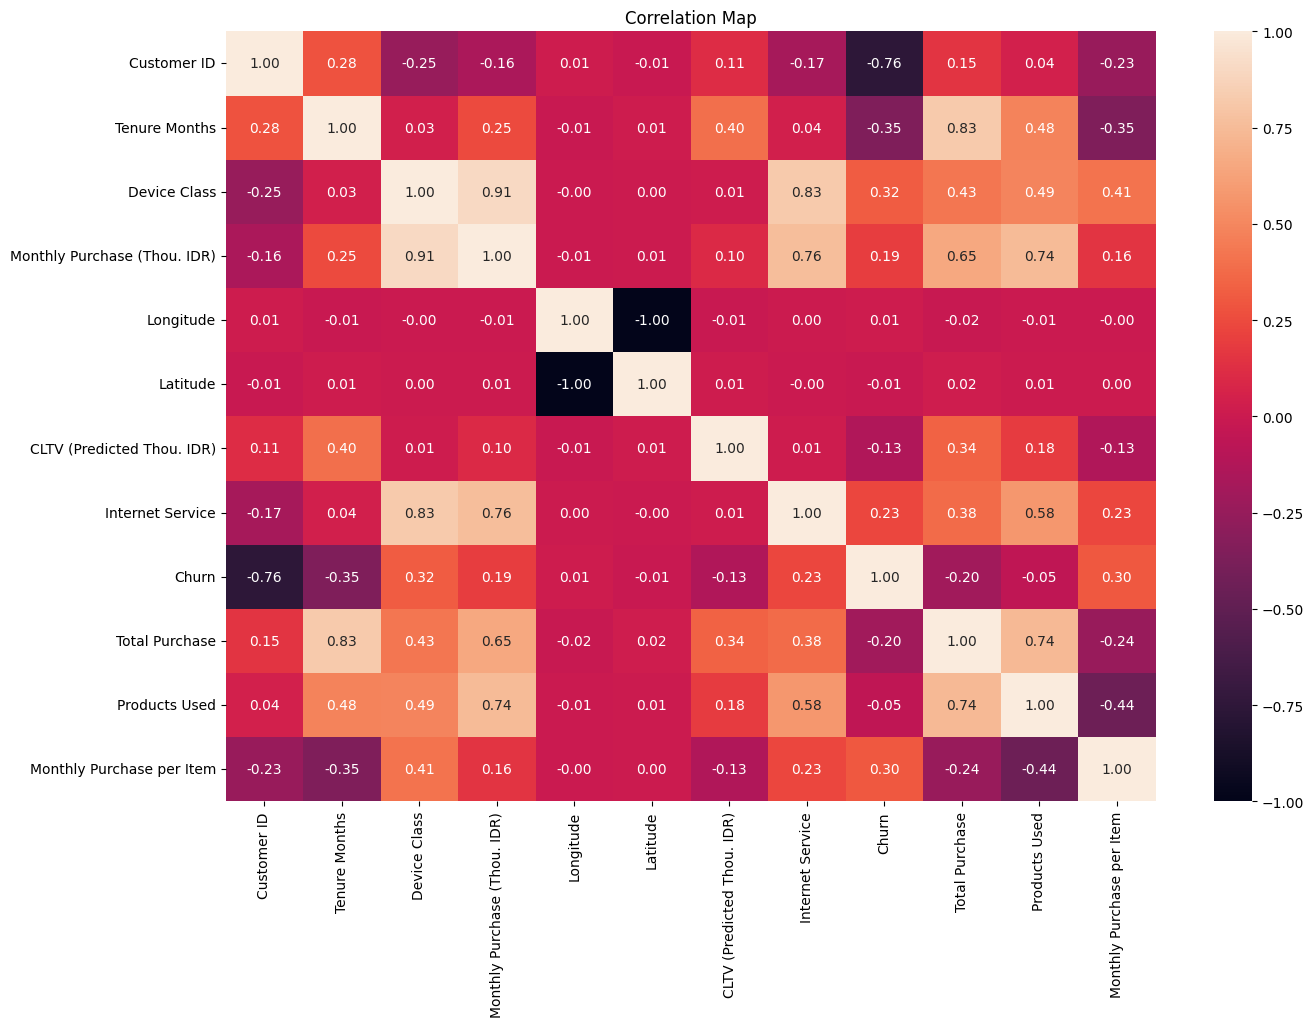

In [32]:
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Modelling

In [5]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, accuracy_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

In [120]:
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model performance
    """
    print(f"""
    METRICS
    Accuracy: {accuracy_score(y_true, y_pred)}
    Precision: {precision_score(y_true, y_pred)}
    Recall: {recall_score(y_true, y_pred)}
    F1 Score: {f1_score(y_true, y_pred)}
    ROC AUC score: {roc_auc_score(y_true, y_pred)}
    Specificity: {specificity_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title("Confusion Matrix of Logistic Regression (aka. Baseline Model)")
    plt.show()

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()

    # swarmplot
    sns.swarmplot(x=y_pred_proba[:, 1], hue=y_true.tolist())
    plt.axvline(0.5, label="Threshold", color="red", linestyle="--")
    plt.xticks(np.arange(0, 1.001, 0.1))
    plt.show()

## Baseline Model AKA. Dummy Classifier


    METRICS
    Accuracy: 0.6266855926188787
    Precision: 0.3010471204188482
    Recall: 0.3074866310160428
    F1 Score: 0.30423280423280424
    ROC AUC score: 0.5247578082616446
    Specificity: 0.7420289855072464
    


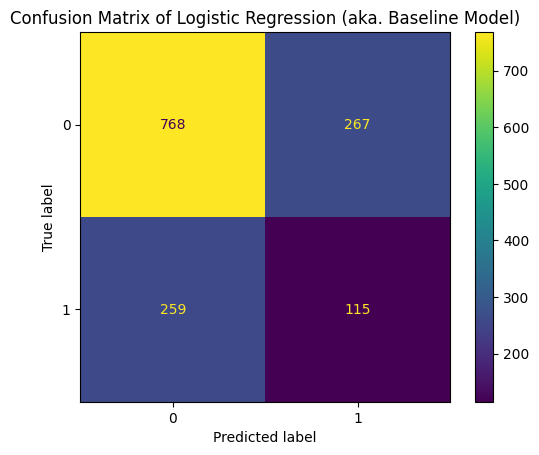

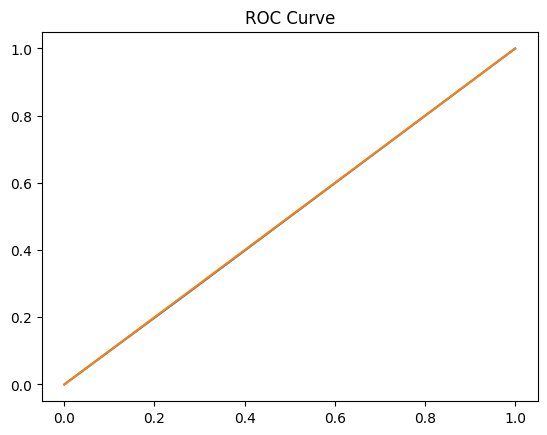

c:\Users\USER\anaconda3\envs\ml-tools\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 48.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\USER\anaconda3\envs\ml-tools\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 94.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


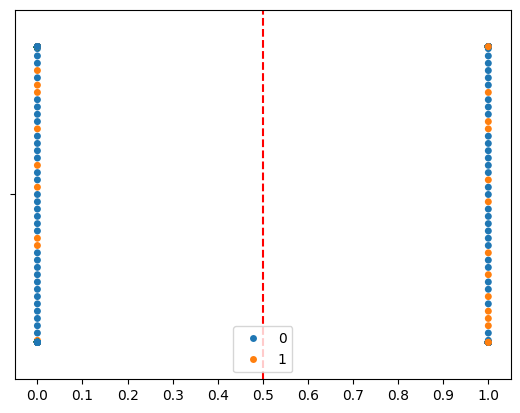

In [35]:
from sklearn.dummy import DummyClassifier
# Data Preparation
# ==============================================
df = df_ori.copy()
df = df.drop(columns=["Customer ID"])  # drop unimportant data
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label

X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Train Dummy Classifier
# ==============================================
model = DummyClassifier(strategy="stratified")
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

## Model Improvement

### Using Different Model

[0.51170569 0.55518395 0.51505017 0.55183946 0.4916388  0.51839465
 0.55183946 0.51505017 0.50167224 0.53511706] 
Score Mean: 0.5247491638795986

    METRICS
    Accuracy: 0.7920511000709723
    Precision: 0.6354515050167224
    Recall: 0.5080213903743316
    F1 Score: 0.5646359583952453
    ROC AUC score: 0.701353690356248
    Specificity: 0.8946859903381642
    


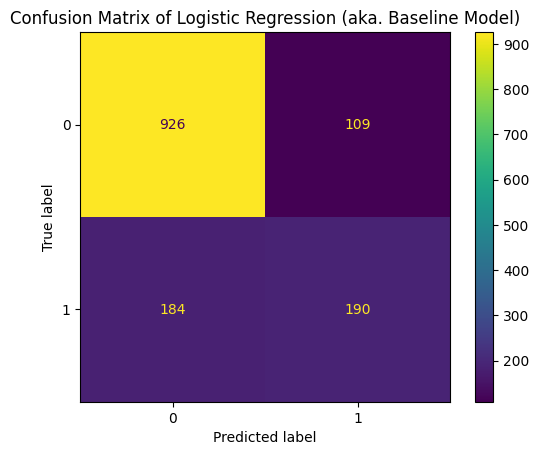

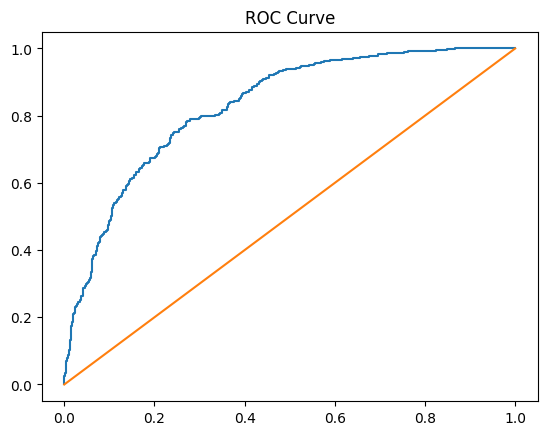

In [77]:
from sklearn.linear_model import LogisticRegression
# Data Preparation
# ==============================================
df = df_ori.copy()
df = df.drop(columns=["Customer ID"])  # drop unimportant data
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label

X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f"\nScore Mean: {score.mean()}")


# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

1. We improve the specificity rate of predicting the negative class from **ground truth negative class**.
2. However we need to improve more on the recall and precision.

### Scaling Data

[0.50167224 0.5451505  0.51505017 0.56521739 0.48160535 0.5083612
 0.56187291 0.48829431 0.49498328 0.51839465] 
Score Mean: 0.5180602006688964

    METRICS
    Accuracy: 0.7934705464868701
    Precision: 0.6397306397306397
    Recall: 0.5080213903743316
    F1 Score: 0.5663189269746647
    ROC AUC score: 0.7023198739311272
    Specificity: 0.8966183574879227
    


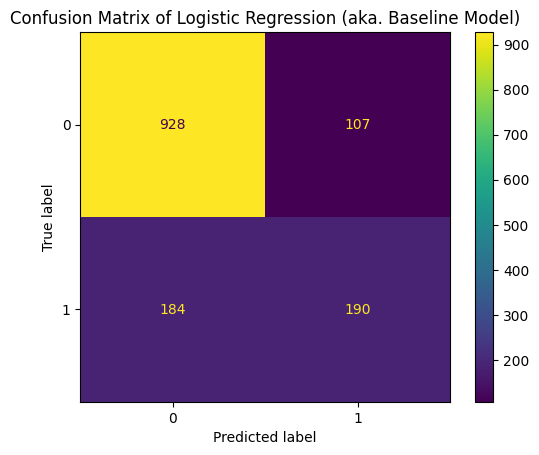

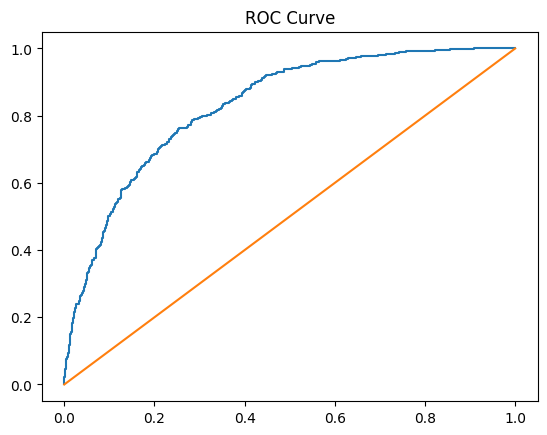

In [78]:
from sklearn.linear_model import LogisticRegression
# Data Preparation
# ==============================================
df = df_ori.copy()
df = df.drop(columns=["Customer ID"])  # drop unimportant data
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f"\nScore Mean: {score.mean()}")


# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

Model improve just a little

### Feature Engineering

In [52]:
# function for feature engineering
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

# def uses_internet_for_product(data):
#     if data == "Yes": return 1
#     return 0

[0.5083612  0.54849498 0.51170569 0.56521739 0.48829431 0.51505017
 0.56187291 0.50501672 0.49832776 0.52173913] 
Score Mean: 0.5224080267558529

    METRICS
    Accuracy: 0.7955997161107168
    Precision: 0.6423841059602649
    Recall: 0.5187165775401069
    F1 Score: 0.57396449704142
    ROC AUC score: 0.7071843757265752
    Specificity: 0.8956521739130435
    


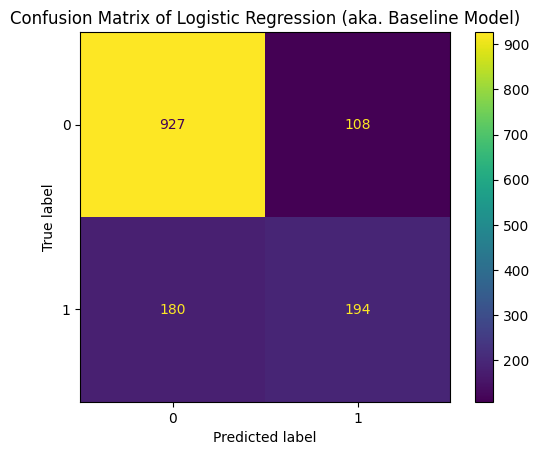

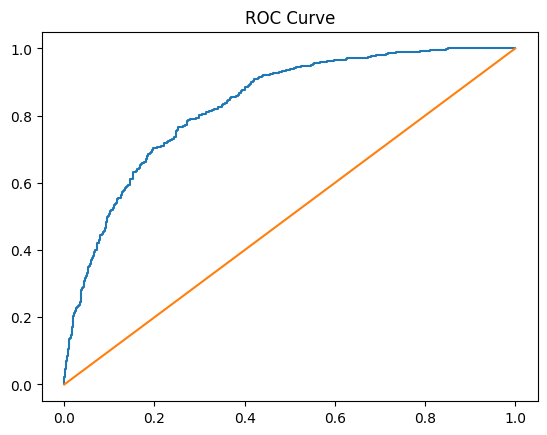

In [80]:
from sklearn.linear_model import LogisticRegression
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=['Customer ID', 'Latitude', 'Longitude', 'Location'])  # drop unimportant data
df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df['Device Class'] = df['Device Class'].replace({'High End': 3, 'Mid End': 2, 'Low End': 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({'Yes': 1, 'No': 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=['Churn Label']), dtype=int), df['Churn Label']  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f'\nScore Mean: {score.mean()}')


# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

Exist some multicllinearity between Total Purchases with CLTV, Tenure Months, Monthly Purchase and Device Classes. Let's try to perform PCA on it

### Perform Oversampling
Oversampling is used to tackle imbalance class problem

[0.83091787 0.80917874 0.81400966 0.83937198 0.81884058 0.81280193
 0.8236715  0.82729469 0.82004831 0.83333333] 
Score Mean: 0.8229468599033817

    METRICS
    Accuracy: 0.7927608232789212
    Precision: 0.6273291925465838
    Recall: 0.5401069518716578
    F1 Score: 0.5804597701149424
    ROC AUC score: 0.7120824614430753
    Specificity: 0.8840579710144928
    


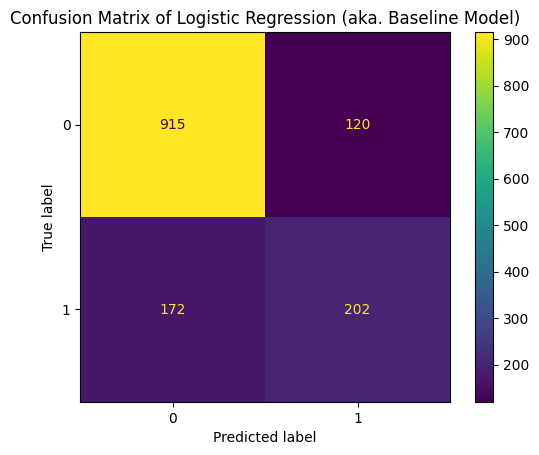

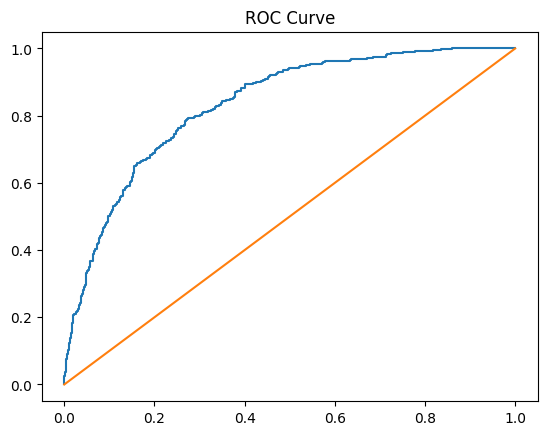

In [8]:
from sklearn.linear_model import LogisticRegression

# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f"\nScore Mean: {score.mean()}")


# Train
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

Performing Oversampling cause overfitting let's try other models. Especially those that are able to tackle imbalanced dataset problem.

### Try Other Models

In [9]:
# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

models = [
    LogisticRegression(random_state=42, max_iter=200), SVC(probability=True), KNeighborsClassifier(), GaussianNB(),
    DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42), 
    AdaBoostClassifier(random_state=42), GradientBoostingClassifier(random_state=42), XGBClassifier(random_state=42),
    CatBoostClassifier(random_state=42), LGBMClassifier(objective='binary', random_state=42), ExtraTreesClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []
threshold=0.5

for model in models:
    # Data Preparation
    # ==============================================
    df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
    df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    # Oversampling for balancing dataset
    # ==============================================
    smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
    X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

    # Scale data
    # ========================================
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING
    
    # Cross Validation
    # ========================================
    cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    f1s.append(score.mean())
    print(f"{model.__class__.__name__} done")

    
df_model = pd.DataFrame(
    {
        "Model Name": [model.__class__.__name__ for model in models],
        "F1 Score": f1s,
    }
)

df_model.sort_values(by="F1 Score", ascending=False)

LogisticRegression done
SVC done
KNeighborsClassifier done
GaussianNB done
DecisionTreeClassifier done
RandomForestClassifier done
AdaBoostClassifier done
GradientBoostingClassifier done
XGBClassifier done
Learning rate set to 0.023094
0:	learn: 0.6753298	total: 678ms	remaining: 11m 17s
1:	learn: 0.6589765	total: 689ms	remaining: 5m 44s
2:	learn: 0.6411557	total: 697ms	remaining: 3m 51s
3:	learn: 0.6299985	total: 702ms	remaining: 2m 54s
4:	learn: 0.6142943	total: 707ms	remaining: 2m 20s
5:	learn: 0.6039375	total: 711ms	remaining: 1m 57s
6:	learn: 0.5922827	total: 714ms	remaining: 1m 41s
7:	learn: 0.5791026	total: 717ms	remaining: 1m 28s
8:	learn: 0.5705236	total: 720ms	remaining: 1m 19s
9:	learn: 0.5622388	total: 724ms	remaining: 1m 11s
10:	learn: 0.5525438	total: 727ms	remaining: 1m 5s
11:	learn: 0.5436022	total: 730ms	remaining: 1m
12:	learn: 0.5364373	total: 733ms	remaining: 55.6s
13:	learn: 0.5301941	total: 736ms	remaining: 51.8s
14:	learn: 0.5240365	total: 739ms	remaining: 48.5s
1

,Model Name,F1 Score
9,CatBoostClassifier,0.858536
7,GradientBoostingClassifier,0.858104
10,LGBMClassifier,0.857976
0,LogisticRegression,0.855098
6,AdaBoostClassifier,0.852015
8,XGBClassifier,0.849395
5,RandomForestClassifier,0.845757
1,SVC,0.843495
11,ExtraTreesClassifier,0.832639
2,KNeighborsClassifier,0.824243


CatBoostClassifier, GradientBoostingClassifier, LGBMClassifier, LogisticRegression, AdaBoostClassifier are the best models. Let's check on the performance on test data

In [79]:
# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

models = [
    LogisticRegression(random_state=42, max_iter=200), AdaBoostClassifier(random_state=42), XGBClassifier(random_state=42),
    CatBoostClassifier(random_state=42), LGBMClassifier(objective='binary', random_state=42), GaussianNB()
]

recalls = []
precisions = []
f1s = []
roc_aucs = []
threshold=0.5

for model in models:
    # Data Preparation
    # ==============================================
    df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
    df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    # Oversampling for balancing dataset
    # ==============================================
    smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
    X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

    # Scale data
    # ========================================
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING
    
    # Train
    # ==============================================
    model.fit(X_train, y_train)
    

    # Predict
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:, 1]]
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred))
    
df_model = pd.DataFrame(
    {
        "Model Name": [model.__class__.__name__ for model in models],
        "Threshold": [threshold for _ in range(len(models))],
        "Recall": recalls,
        "Precisions": precisions,
        "F1 Score": f1s,
        "ROC AUC Score": roc_aucs,
    }
)

df_model.sort_values(by="F1 Score", ascending=False)

# Hyperparameter Tuning

## Logistic Regression

In [24]:
import optuna

# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    C = trial.suggest_float("C", 0.0001, 1.0, log=True)
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "newton-cg"])
    # Cross validation
    # ==============================================
    model = LogisticRegression(C=C, solver=solver, random_state=42, max_iter=200)    
    cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_log_loss')
    return score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_value)
print(study.best_params)

# Train using best parameters
# ==============================================
model = LogisticRegression(**study.best_params, random_state=42)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-03 14:06:22,155] A new study created in memory with name: no-name-feee5432-b8e9-42a0-8776-a5685a85d30f
[I 2023-11-03 14:06:22,363] Trial 0 finished with value: -0.31228936331852175 and parameters: {'C': 0.07093538524624585, 'solver': 'lbfgs'}. Best is trial 0 with value: -0.31228936331852175.
[I 2023-11-03 14:06:22,598] Trial 1 finished with value: -0.3658474694437101 and parameters: {'C': 0.003319711988817214, 'solver': 'liblinear'}. Best is trial 0 with value: -0.31228936331852175.
[I 2023-11-03 14:06:22,805] Trial 2 finished with value: -0.3120201193544071 and parameters: {'C': 0.07358040174284987, 'solver': 'lbfgs'}. Best is trial 2 with value: -0.3120201193544071.
[I 2023-11-03 14:06:23,220] Trial 3 finished with value: -0.39651805393217227 and parameters: {'C': 0.0015096002921513429, 'solver': 'newton-cg'}. Best is trial 2 with value: -0.3120201193544071.
[I 2023-11-03 14:06:23,439] Trial 4 finished with value: -0.5153401179938282 and parameters: {'C': 0.00020057405503

-0.30261645842963547
{'C': 0.9706609831264408, 'solver': 'newton-cg'}

Recalls: 0.540
Precision: 0.627
F1 Score: 0.580
ROC AUC SCORE: 0.712



## CatBoostClassifier

In [116]:
import optuna
import catboost as cb

# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # Cross validation
    # ==============================================
    model = cb.CatBoostClassifier(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)
    preds = model.predict(X_val)
    y_pred = np.rint(preds)
    return f1_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = cb.CatBoostClassifier(**study.best_params)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)


# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-03 16:56:11,137] A new study created in memory with name: no-name-96607c3f-4b01-4ee7-a52c-3497524b648a
[I 2023-11-03 16:56:19,352] Trial 0 finished with value: 0.5991111111111111 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.032352935966929904, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.462589556000604}. Best is trial 0 with value: 0.5991111111111111.
[I 2023-11-03 16:56:26,080] Trial 1 finished with value: 0.6167913549459684 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.021744393655497858, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.8469687382828743}. Best is trial 1 with value: 0.6167913549459684.
[I 2023-11-03 16:56:32,873] Trial 2 finished with value: 0.5918552036199094 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.025385071089771213, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'b

0.6254071661237784
{'objective': 'Logloss', 'colsample_bylevel': 0.01403718515662937, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.9900382710819517}

Recalls: 0.679
Precision: 0.568
F1 Score: 0.619
ROC AUC SCORE: 0.746



## XGBClassifier

In [114]:
import optuna
import xgboost as xgb

# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Transform data into DMatrix
# ==============================================
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)
# Hyperparameter Tuning
# ==============================================
def objective(trial):

    # Hyperparameters
    # ==============================================
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 10, step=1)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    return f1_score(y_val, pred_labels)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = xgb.train(study.best_params, dtrain)

# Predict
# ==============================================
preds = model.predict(dtest)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")


[I 2023-11-03 16:51:02,309] A new study created in memory with name: no-name-a6b2b848-9c3b-445c-a50a-f96a69342f7c
[I 2023-11-03 16:51:02,409] Trial 0 finished with value: 0.6018287614297589 and parameters: {'booster': 'dart', 'lambda': 2.9029361956449015e-06, 'alpha': 0.09516446923901327, 'subsample': 0.23832563220180836, 'colsample_bytree': 0.41686706901351844, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.016077828208538987, 'gamma': 0.00019510848998490003, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.006973551552967848, 'skip_drop': 5.28247231904509e-08}. Best is trial 0 with value: 0.6018287614297589.
[I 2023-11-03 16:51:02,434] Trial 1 finished with value: 0.6004198740377887 and parameters: {'booster': 'gbtree', 'lambda': 0.06768322356417329, 'alpha': 0.01380062373268307, 'subsample': 0.23856682554246886, 'colsample_bytree': 0.5407158490959867, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.048883215503614054, 'gamma': 0.00035

Number of finished trials:  100
Best trial:
  Value: 0.6284779050736498
  Params: 
    booster: gbtree
    lambda: 2.0767792009562707e-07
    alpha: 0.06321279655447397
    subsample: 0.7205564529817828
    colsample_bytree: 0.6183420536111108
    max_depth: 7
    min_child_weight: 8
    eta: 3.532418058201353e-06
    gamma: 0.002151230605017903
    grow_policy: lossguide

Recalls: 0.652
Precision: 0.580
F1 Score: 0.614
ROC AUC SCORE: 0.741



## LGBMClassifier

In [112]:
import optuna
import lightgbm as lgb


# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_val)
    y_pred = np.rint(preds)
    return f1_score(y_val, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_value)
print(study.best_params)

# Train using best parameters
# ==============================================
model = LGBMClassifier(**study.best_params, verbose=-1, random_state=42)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")    


[I 2023-11-03 16:47:44,723] A new study created in memory with name: no-name-c2a074fc-aab4-42ea-93da-c7703bf958f4
[I 2023-11-03 16:47:45,141] Trial 0 finished with value: 0.5470085470085471 and parameters: {'lambda_l1': 0.001734018550042218, 'lambda_l2': 1.7485828724904358, 'num_leaves': 60, 'feature_fraction': 0.49191540247880067, 'bagging_fraction': 0.9737423047070976, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 0 with value: 0.5470085470085471.
[I 2023-11-03 16:47:45,379] Trial 1 finished with value: 0.5652173913043478 and parameters: {'lambda_l1': 2.622160463056406, 'lambda_l2': 1.9034802884785314e-06, 'num_leaves': 88, 'feature_fraction': 0.5058618320546059, 'bagging_fraction': 0.7996472542782094, 'bagging_freq': 1, 'min_child_samples': 79}. Best is trial 1 with value: 0.5652173913043478.
[I 2023-11-03 16:47:45,743] Trial 2 finished with value: 0.533462657613967 and parameters: {'lambda_l1': 0.0007627155735703801, 'lambda_l2': 0.06924911877700526, 'num_leaves': 79, 

0.6097972972972973
{'lambda_l1': 0.5941715396674172, 'lambda_l2': 0.001980874010821108, 'num_leaves': 3, 'feature_fraction': 0.9667946442773463, 'bagging_fraction': 0.7771613182271817, 'bagging_freq': 2, 'min_child_samples': 9}

Recalls: 0.652
Precision: 0.584
F1 Score: 0.616
ROC AUC SCORE: 0.742



## AdaBoostClassifier

In [48]:
import optuna

# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    }
    

    # Cross validation
    # ==============================================
    model = AdaBoostClassifier(**param, random_state=42)
    cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_value)
print(study.best_params)

# Train using best parameters
# ==============================================
model = AdaBoostClassifier(**study.best_params, random_state=42)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")    


[I 2023-11-03 15:20:20,179] A new study created in memory with name: no-name-4f50c1ab-62ee-46ef-96a8-458fc8867a4d
[I 2023-11-03 15:20:25,193] Trial 0 finished with value: 0.7785140758339288 and parameters: {'n_estimators': 77, 'learning_rate': 0.00766318016292438}. Best is trial 0 with value: 0.7785140758339288.
[I 2023-11-03 15:20:40,778] Trial 1 finished with value: 0.8485094672889986 and parameters: {'n_estimators': 254, 'learning_rate': 0.1763306118597426}. Best is trial 1 with value: 0.8485094672889986.
[I 2023-11-03 15:21:02,255] Trial 2 finished with value: 0.8408141526027635 and parameters: {'n_estimators': 342, 'learning_rate': 0.07054330934660959}. Best is trial 1 with value: 0.8485094672889986.
[I 2023-11-03 15:21:29,616] Trial 3 finished with value: 0.8356594480913309 and parameters: {'n_estimators': 438, 'learning_rate': 0.04301549789603253}. Best is trial 1 with value: 0.8485094672889986.
[I 2023-11-03 15:21:39,196] Trial 4 finished with value: 0.8082997827908642 and para

0.8529850645144877
{'n_estimators': 265, 'learning_rate': 0.2757584905727323}

Recalls: 0.615
Precision: 0.588
F1 Score: 0.601
ROC AUC SCORE: 0.730



## Navie Bayes

In [91]:
import optuna
import xgboost as xgb

# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "var_smoothing": trial.suggest_float("var_smoothing", 1e-9, 1.0, log=True),
    }
    model = GaussianNB(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = GaussianNB(**study.best_params)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-03 16:11:28,421] A new study created in memory with name: no-name-1a30ebd6-493d-4295-adeb-6141c35bc043
[I 2023-11-03 16:11:28,438] Trial 0 finished with value: 0.5690954773869347 and parameters: {'var_smoothing': 0.005162001292123669}. Best is trial 0 with value: 0.5690954773869347.
[I 2023-11-03 16:11:28,452] Trial 1 finished with value: 0.5690954773869347 and parameters: {'var_smoothing': 0.008328351793446678}. Best is trial 0 with value: 0.5690954773869347.
[I 2023-11-03 16:11:28,466] Trial 2 finished with value: 0.562844880441447 and parameters: {'var_smoothing': 0.0838305534260639}. Best is trial 0 with value: 0.5690954773869347.
[I 2023-11-03 16:11:28,480] Trial 3 finished with value: 0.5703470031545742 and parameters: {'var_smoothing': 1.8223407500858561e-09}. Best is trial 3 with value: 0.5703470031545742.
[I 2023-11-03 16:11:28,492] Trial 4 finished with value: 0.5647348951911221 and parameters: {'var_smoothing': 0.059611932117537944}. Best is trial 3 with value: 0.

Number of finished trials:  100
Best trial:
  Value: 0.5712484237074401
  Params: 
    var_smoothing: 0.00046798010735194016

Recalls: 0.797
Precision: 0.432
F1 Score: 0.560
ROC AUC SCORE: 0.709



# Inspect Best Model (Cat Boost)


Recalls: 0.679
Precision: 0.568
F1 Score: 0.619
ROC AUC SCORE: 0.746


    METRICS
    Accuracy: 0.7778566359119943
    Precision: 0.5682326621923938
    Recall: 0.679144385026738
    F1 Score: 0.6187576126674786
    ROC AUC score: 0.7463354775375236
    Specificity: 0.8135265700483092
    


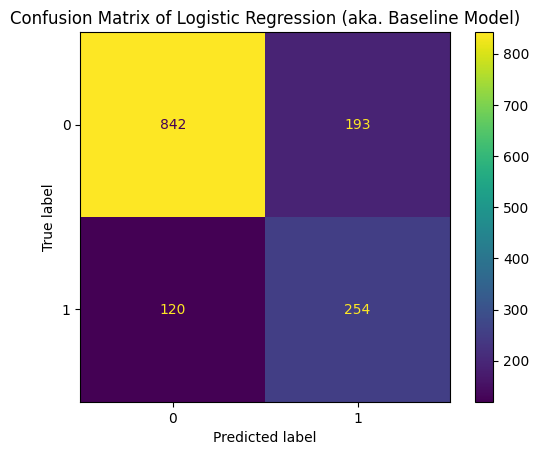

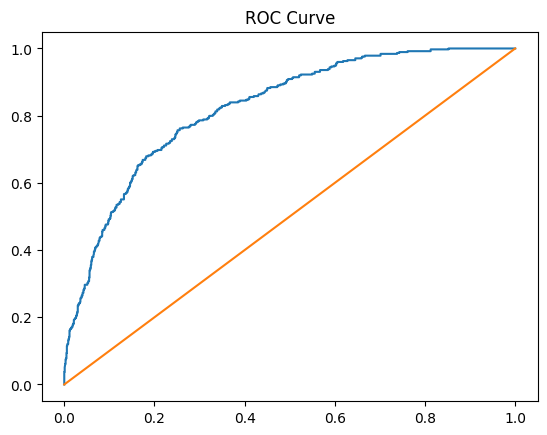

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\seaborn\categorical.py:3370: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


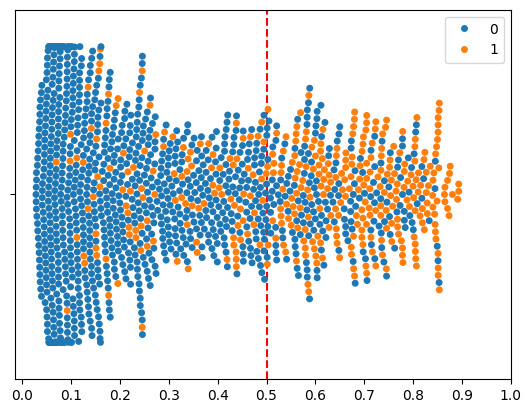

In [121]:
import optuna
import catboost as cb

# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID"])  # drop unimportant data
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data (tree model don't need for scaling)
# ==============================================
# X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
# X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
# X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING


# Best Param
param = {
    'objective': 'Logloss', 
    'colsample_bylevel': 0.01403718515662937, 
    'depth': 3, 
    'boosting_type': 'Plain', 
    'bootstrap_type': 'Bayesian', 
    'bagging_temperature': 3.9900382710819517
}

# Train using best parameters
# ==============================================
model = cb.CatBoostClassifier(**study.best_params)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)


# Predict
# ==============================================
preds = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
y_pred = np.rint(preds)

print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

evaluate(model, y_test, y_pred, y_pred_proba)
